In [1]:
import sys
import time
import random
from os.path import exists
from typing import *

# Common data science imports
import numpy as np
import pandas as pd
import torch
from torch.utils.data import random_split, DataLoader, Dataset
from sklearn.cluster import KMeans

# Visualization tools
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from tqdm import tqdm, notebook as tqdm_notebook

# GPyTorch and linear_operator imports
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.constraints import *
import linear_operator
from linear_operator.settings import max_cholesky_size
from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.utils.cholesky import psd_safe_cholesky

# Custom soft GP and MLL imports
from gp.soft_gp.soft_gp import SoftGP
from gp.soft_gp.mll import HutchinsonPseudoLoss
from linear_solver.cg import linear_cg

# Data analysis and UCI dataset

# Utility functions for dataset handling
from gp.util import flatten_dataset, split_dataset, filter_param

# Experiment tracking
import wandb

# System path adjustments
sys.path.append("../")

In [2]:
def eval_gp(model, test_dataset: Dataset, device="cuda:0") -> float:
    preds = []
    neg_mlls = []
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=1)
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds += [(model.pred(x_batch) - y_batch).detach().cpu()**2]
        neg_mlls += [-model.mll(x_batch, y_batch).detach().cpu()]
    rmse = torch.sqrt(torch.sum(torch.cat(preds)) / len(test_dataset)).item()
    neg_mll = torch.sum(torch.tensor(neg_mlls))
            
    print("RMSE:", rmse, "NEG_MLL", neg_mll.item(), "NOISE", model.noise.cpu().item(), "LENGTHSCALE", model.get_lengthscale(), "OUTPUTSCALE", model.get_outputscale())# "T",model.T)
    
    return {
        "rmse": rmse,
        "nll": neg_mll,
    }   
   

In [14]:
#==================Dataset============================
from data.get_uci import ElevatorsDataset,PoleteleDataset,ProteinDataset, KeggDirectedDataset
# # dataset = ElevatorsDataset("../data/uci_datasets/uci_datasets/elevators/data.csv")
# dataset = PoleteleDataset("../data/uci_datasets/uci_datasets/pol/data.csv")
# dataset = ProteinDataset("../data/uci_datasets/uci_datasets/protein/data.csv")
dataset = KeggDirectedDataset("../data/uci_datasets/uci_datasets/keggdirected/data.csv")
# dataset = CTSlicesDataset("../data/uci_datasets/uci_datasets/slice/data.csv")
train_dataset, val_dataset, test_dataset = split_dataset(
    dataset,
    train_frac=9/10, #TODO change to real vals 
    val_frac=0/10
)

def plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs,  legend_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    epochs_range = range(1, epochs + 1)

    # Plot RMSE per Epoch for each model (baseline + CG tolerances)
    for i in range(len(legend_names)):
        label = legend_names[i]  # Use the provided names from legend_names list
        axes[0].plot(epochs_range, all_mean_rmse[i], label=label)
        
        # Fill between the RMSE values for standard deviation
        axes[0].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             [m + s for m, s in zip(all_mean_rmse[i], all_std_rmse[i])],
                             alpha=0.3)

    axes[0].set_title('RMSE per Epoch')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('RMSE')
    axes[0].legend()

    # Plot Training Time per Epoch for each model (baseline + CG tolerances)
    for i in range(len(legend_names)):
        label = legend_names[i]  # Use the provided names from legend_names list
        axes[1].plot(epochs_range, all_mean_runtimes[i], label=label)
        
        # Fill between the runtime values for standard deviation
        axes[1].fill_between(epochs_range,
                             [m - s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             [m + s for m, s in zip(all_mean_runtimes[i], all_std_runtimes[i])],
                             alpha=0.3)

    axes[1].set_title('Training Time per Epoch')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Time (s)')
    # axes[1].legend()

    plt.tight_layout()
    plt.savefig("keggdirected_solvers.png")
    plt.show()

def train_gp(GP_class, inducing_points, test_dataset, train_features, train_labels, epochs, device, dtype, model_config=None):
    print(device)
    print(inducing_points.device)
    model_config = model_config or {}
    # kernel = RBFKernel().to(device=device, dtype=dtype)
    kernel = RBFKernel()
    learn_noise = model_config.get("learn_noise", False)
    lr = model_config.get("learning_rate", 0.01)
    batch_size = model_config.get("batch_size", 1024)

    model = GP_class(
        kernel,
        inducing_points,
        noise=model_config.get("noise", 1e-3),
        learn_noise=learn_noise,
        use_scale=model_config.get("use_scale", True),
        dtype=dtype,
        device=device,
        max_cg_iter=1000,
        solver=model_config.get("solver", "solve"),
        mll_approx=model_config.get("mll_approx", "hutchinson"),
        fit_chunk_size=model_config.get("fit_chunk_size", 1024),
        use_qr=model_config.get("use_qr", True),
        hutch_solver = model_config.get("hutch_solver", "solve"),
    )


    epoch_runtimes = []
    epoch_rmse = []

    # pbar = tqdm(range(epochs), desc="Optimizing MLL")
    if learn_noise:
        params = model.parameters()
    else:
        params = filter_param(model.named_parameters(), "likelihood.noise_covar.raw_noise")
    optimizer = torch.optim.Adam(params, lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    def train_model():
        #==================Train============================
        for _ in tqdm(range(epochs)):
            print("training current epoch")
            epoch_start_time = time.time()

            for x_batch, y_batch in train_loader:
                x_batch = x_batch.clone().detach().to(dtype=dtype, device=device)
                y_batch = y_batch.clone().detach().to(dtype=dtype, device=device)
                optimizer.zero_grad()
                with gpytorch.settings.max_root_decomposition_size(100), max_cholesky_size(int(1.e7)), gpytorch.settings.max_preconditioner_size(15):
                    neg_mll = -model.mll(x_batch, y_batch)
                neg_mll.backward()
                optimizer.step()
            model.fit(train_features, train_labels)
            epoch_end_time = time.time()
            epoch_runtimes.append(epoch_end_time - epoch_start_time)

            #==================Evaluate============================
            print("Running eval")
            eval_results = eval_gp(model, test_dataset, device=device)
            epoch_rmse.append(eval_results['rmse'])
            print("eval finished")    
    train_model()
    return epoch_rmse, epoch_runtimes

SIZE (48827, 21)


In [7]:
def benchmark(train_dataset, test_dataset, epochs=2, seed=42, N=3, configs=None):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    num_inducing = 512
    dtype = torch.float32
    device = "cuda:0"
    
    all_mean_rmse = []
    all_mean_runtimes = []
    all_std_rmse = []
    all_std_runtimes = []

    #==================Inducing Points============================
    train_features, train_labels = flatten_dataset(train_dataset)
    kmeans = KMeans(n_clusters=num_inducing)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    inducing_points = torch.tensor(centers).to(dtype=dtype, device=device)

    if configs is None:
        raise ValueError("You must provide a list of configurations in 'configs'")

    for config in configs:
        all_runs_rmse = []
        all_runs_runtimes = []

        solver_name = config.get("solver", "Unknown Solver")
        print(f"Running model with solver '{solver_name}'")

        for run in range(N):
            epoch_rmse, epoch_runtimes = train_gp(
                SoftGP,
                inducing_points.clone(),
                test_dataset,
                train_features,
                train_labels,
                epochs,
                device,
                dtype,
                model_config=config  # Pass current config
            )
            all_runs_rmse.append(epoch_rmse)
            all_runs_runtimes.append(epoch_runtimes)

        # Calculate mean and std deviation across the N runs for the current configuration
        mean_rmse = np.mean(all_runs_rmse, axis=0)
        std_rmse = np.std(all_runs_rmse, axis=0)
        mean_runtimes = np.mean(all_runs_runtimes, axis=0)
        std_runtimes = np.std(all_runs_runtimes, axis=0)

        all_mean_rmse.append(mean_rmse)
        all_mean_runtimes.append(mean_runtimes)
        all_std_rmse.append(std_rmse)
        all_std_runtimes.append(std_runtimes)

    return all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes

#==================Benchmark============================

# Example configurations
configs = [
    {"solver": "solve", "hutch_solver": "solve", "use_qr": True},  # Baseline
    {"solver": "solve", "hutch_solver": "cg","cg_tolerance": 1e-4,"use_qr": True},
    {"solver": "solve", "hutch_solver": "cholesky","use_qr": True},


    # {"solver": "cg", "cg_tolerance": 1e-8, "use_qr": True},
    # {"solver": "cg", "cg_tolerance": 0.5, "use_qr": True},
    # {"solver": "cg", "cg_tolerance": 1, "use_qr": True},
    # {"solver": "new_method", "parameter1": 0.1, "parameter2": True}  # Example for a new method
]



epochs = 50
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark(train_dataset, test_dataset, epochs=epochs, seed=6535, N=N, configs=configs)

  0%|          | 0/6 [00:00<?, ?it/s]

Running model with solver 'solve'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:36,  4.42s/it]

RMSE: 0.08865618705749512 NEG_MLL -978.8214721679688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9234]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8928, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:18,  4.14s/it]

RMSE: 0.08733983337879181 NEG_MLL -690.5875244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1146]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0404, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:03,  3.91s/it]

RMSE: 0.08669434487819672 NEG_MLL -578.9786376953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2384]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1661, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:15<02:54,  3.79s/it]

RMSE: 0.08615750819444656 NEG_MLL -508.3608703613281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3357]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2819, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:19<02:52,  3.83s/it]

RMSE: 0.08574216067790985 NEG_MLL -469.8324890136719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4038]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3923, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:23<02:49,  3.86s/it]

RMSE: 0.08548201620578766 NEG_MLL -443.90655517578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4674]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5015, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:27<02:45,  3.84s/it]

RMSE: 0.08529882878065109 NEG_MLL -415.262451171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5103]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6082, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:30<02:38,  3.76s/it]

RMSE: 0.0851154699921608 NEG_MLL -403.4334411621094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5497]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7117, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:34<02:32,  3.73s/it]

RMSE: 0.08526245504617691 NEG_MLL -389.90576171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5906]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8104, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:38<02:27,  3.69s/it]

RMSE: 0.08510832488536835 NEG_MLL -376.67327880859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6182]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9106, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:41<02:21,  3.64s/it]

RMSE: 0.08491769433021545 NEG_MLL -371.48858642578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6418]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0074, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:45<02:20,  3.69s/it]

RMSE: 0.08498793840408325 NEG_MLL -362.50823974609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6603]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1019, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:48<02:14,  3.65s/it]

RMSE: 0.08470331877470016 NEG_MLL -361.18719482421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6825]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1977, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:52<02:09,  3.59s/it]

RMSE: 0.08450388163328171 NEG_MLL -346.6283874511719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6955]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2950, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [00:56<02:06,  3.62s/it]

RMSE: 0.084550641477108 NEG_MLL -329.9751281738281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7193]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3821, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [00:59<02:03,  3.64s/it]

RMSE: 0.08458101749420166 NEG_MLL -340.3656005859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7351]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4626, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:03<02:02,  3.71s/it]

RMSE: 0.08462532609701157 NEG_MLL -341.6280212402344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7052]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5545, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:07<01:57,  3.68s/it]

RMSE: 0.08446700870990753 NEG_MLL -342.48333740234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7026]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6511, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:10<01:52,  3.63s/it]

RMSE: 0.08447103202342987 NEG_MLL -331.5459899902344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7278]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7429, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:14<01:48,  3.63s/it]

RMSE: 0.08443067967891693 NEG_MLL -322.5452575683594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7454]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8319, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:17<01:44,  3.60s/it]

RMSE: 0.08454521745443344 NEG_MLL -312.6886901855469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7648]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9195, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:21<01:40,  3.58s/it]

RMSE: 0.08454100787639618 NEG_MLL -308.44207763671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7753]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0019, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:25<01:40,  3.70s/it]

RMSE: 0.08450423181056976 NEG_MLL -312.4345397949219 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7926]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0835, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:29<01:35,  3.67s/it]

RMSE: 0.08442165702581406 NEG_MLL -307.48687744140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8023]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1673, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:32<01:32,  3.69s/it]

RMSE: 0.08447355777025223 NEG_MLL -311.0365295410156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7631]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2571, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:36<01:27,  3.65s/it]

RMSE: 0.08448811620473862 NEG_MLL -307.2705993652344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7447]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3474, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:40<01:25,  3.71s/it]

RMSE: 0.08443918079137802 NEG_MLL -298.936767578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7523]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4350, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:43<01:21,  3.72s/it]

RMSE: 0.08431390672922134 NEG_MLL -296.3197937011719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7571]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5230, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [01:47<01:17,  3.68s/it]

RMSE: 0.08437643945217133 NEG_MLL -294.0599060058594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7445]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6132, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [01:51<01:13,  3.69s/it]

RMSE: 0.08447547256946564 NEG_MLL -284.0602722167969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7718]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6979, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [01:54<01:09,  3.68s/it]

RMSE: 0.08433357626199722 NEG_MLL -282.75653076171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7958]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7746, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [01:58<01:06,  3.69s/it]

RMSE: 0.08424863964319229 NEG_MLL -278.2809143066406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8227]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8482, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:02<01:03,  3.76s/it]

RMSE: 0.08420911431312561 NEG_MLL -281.8618469238281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7977]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9233, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:06<00:59,  3.72s/it]

RMSE: 0.08417578786611557 NEG_MLL -283.2359313964844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7659]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0072, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:09<00:55,  3.69s/it]

RMSE: 0.08400257676839828 NEG_MLL -280.43560791015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7624]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0908, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:13<00:52,  3.74s/it]

RMSE: 0.08409833908081055 NEG_MLL -277.9638671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8112]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1688, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:17<00:49,  3.81s/it]

RMSE: 0.08400934189558029 NEG_MLL -274.5862121582031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8337]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2506, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:21<00:44,  3.73s/it]

RMSE: 0.08400492370128632 NEG_MLL -269.8773498535156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7963]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3318, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:25<00:41,  3.76s/it]

RMSE: 0.08399391919374466 NEG_MLL -260.134033203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8452]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4071, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:28<00:37,  3.76s/it]

RMSE: 0.0839117169380188 NEG_MLL -261.1279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8454]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4867, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:32<00:33,  3.71s/it]

RMSE: 0.08389817178249359 NEG_MLL -257.69293212890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8529]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5659, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:36<00:29,  3.73s/it]

RMSE: 0.08385975658893585 NEG_MLL -259.1041564941406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8577]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6450, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [02:39<00:25,  3.70s/it]

RMSE: 0.08398231118917465 NEG_MLL -254.4930877685547 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8916]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7231, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [02:43<00:22,  3.69s/it]

RMSE: 0.0840870663523674 NEG_MLL -257.78045654296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8929]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7987, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
 90%|█████████ | 45/50 [02:47<00:18,  3.69s/it]

RMSE: 0.08407575637102127 NEG_MLL -255.56597900390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9078]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8741, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [02:50<00:14,  3.68s/it]

RMSE: 0.08392982184886932 NEG_MLL -247.890380859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9340]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9472, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [02:54<00:10,  3.66s/it]

RMSE: 0.08400917053222656 NEG_MLL -254.2737579345703 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8814]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0246, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [02:58<00:07,  3.67s/it]

RMSE: 0.0838850811123848 NEG_MLL -244.33660888671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9227]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0976, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:01<00:03,  3.69s/it]

RMSE: 0.08406027406454086 NEG_MLL -245.59561157226562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9026]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1703, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:05<00:00,  3.71s/it]


RMSE: 0.08420734107494354 NEG_MLL -246.8992156982422 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9476]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2417, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'solve'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:34,  4.37s/it]

RMSE: 0.08889468759298325 NEG_MLL -959.163818359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9269]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8878, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:28,  4.35s/it]

RMSE: 0.0875086635351181 NEG_MLL -693.119140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1067]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0348, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:13<03:30,  4.47s/it]

RMSE: 0.08676237612962723 NEG_MLL -583.2174072265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2294]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1584, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:17<03:23,  4.42s/it]

RMSE: 0.08620811998844147 NEG_MLL -517.5093383789062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3211]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2780, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:22<03:20,  4.45s/it]

RMSE: 0.08582140505313873 NEG_MLL -484.7408142089844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3943]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3911, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:26<03:14,  4.41s/it]

RMSE: 0.08542944490909576 NEG_MLL -446.7709045410156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4474]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5053, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:30<03:06,  4.35s/it]

RMSE: 0.08527231216430664 NEG_MLL -419.0684509277344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4910]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6137, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:35<03:03,  4.37s/it]

RMSE: 0.08512983471155167 NEG_MLL -399.0311584472656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5379]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7194, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:39<03:00,  4.40s/it]

RMSE: 0.08501573652029037 NEG_MLL -394.5246887207031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5723]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8262, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:44<02:58,  4.46s/it]

RMSE: 0.08487313985824585 NEG_MLL -379.22955322265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6153]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9243, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:48<02:55,  4.50s/it]

RMSE: 0.08484049886465073 NEG_MLL -374.2808837890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6281]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0240, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:52<02:47,  4.40s/it]

RMSE: 0.08463923633098602 NEG_MLL -364.5942077636719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6457]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1224, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:57<02:41,  4.35s/it]

RMSE: 0.08477135002613068 NEG_MLL -351.5757751464844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6570]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2188, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:01<02:34,  4.30s/it]

RMSE: 0.08454345166683197 NEG_MLL -341.2969055175781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6857]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3100, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:05<02:32,  4.36s/it]

RMSE: 0.08447074890136719 NEG_MLL -339.0852966308594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7146]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4035, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:10<02:30,  4.43s/it]

RMSE: 0.08435853570699692 NEG_MLL -336.50006103515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7111]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4948, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:14<02:25,  4.40s/it]

RMSE: 0.08457567542791367 NEG_MLL -336.54150390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7283]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5854, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:19<02:20,  4.39s/it]

RMSE: 0.0844077318906784 NEG_MLL -329.82183837890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7270]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6806, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:23<02:15,  4.38s/it]

RMSE: 0.08438102155923843 NEG_MLL -321.2416687011719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7400]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7690, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:27<02:10,  4.36s/it]

RMSE: 0.08421336114406586 NEG_MLL -316.83551025390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7514]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8573, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:32<02:07,  4.40s/it]

RMSE: 0.08415039628744125 NEG_MLL -311.13494873046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7634]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9440, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:36<02:04,  4.46s/it]

RMSE: 0.08401904255151749 NEG_MLL -314.22796630859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7643]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0265, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:41<02:01,  4.50s/it]

RMSE: 0.08399604260921478 NEG_MLL -306.97625732421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7786]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1059, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:46<01:57,  4.51s/it]

RMSE: 0.08390146493911743 NEG_MLL -297.4715270996094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7914]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1900, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:50<01:51,  4.46s/it]

RMSE: 0.08391153812408447 NEG_MLL -293.8311767578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8016]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2735, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:54<01:46,  4.44s/it]

RMSE: 0.08388038724660873 NEG_MLL -287.7961730957031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8392]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3542, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:59<01:42,  4.47s/it]

RMSE: 0.08381439745426178 NEG_MLL -285.910888671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8031]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4340, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [02:03<01:37,  4.44s/it]

RMSE: 0.0837971568107605 NEG_MLL -288.370361328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7991]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5180, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:08<01:33,  4.43s/it]

RMSE: 0.08391830325126648 NEG_MLL -287.31695556640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8177]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5954, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:12<01:29,  4.46s/it]

RMSE: 0.08409428596496582 NEG_MLL -286.37457275390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8149]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6735, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:17<01:25,  4.51s/it]

RMSE: 0.08405987173318863 NEG_MLL -279.5677490234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8110]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7512, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:22<01:26,  4.78s/it]

RMSE: 0.08395997434854507 NEG_MLL -276.51708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7992]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8293, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:27<01:23,  4.94s/it]

RMSE: 0.0837806910276413 NEG_MLL -274.4225158691406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7941]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9101, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:32<01:19,  4.96s/it]

RMSE: 0.0837300568819046 NEG_MLL -273.7964172363281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7838]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9901, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:38<01:14,  5.00s/it]

RMSE: 0.08367816358804703 NEG_MLL -272.54840087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7975]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0674, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:43<01:10,  5.02s/it]

RMSE: 0.08394809067249298 NEG_MLL -272.695068359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8097]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1426, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:48<01:05,  5.07s/it]

RMSE: 0.08375455439090729 NEG_MLL -267.31756591796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8127]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2172, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:53<01:01,  5.16s/it]

RMSE: 0.08376907557249069 NEG_MLL -271.65728759765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8514]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2940, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:58<00:56,  5.17s/it]

RMSE: 0.08372402936220169 NEG_MLL -277.857666015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8711]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3706, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [03:03<00:51,  5.15s/it]

RMSE: 0.08370625972747803 NEG_MLL -270.52166748046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9045]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4432, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [03:09<00:46,  5.12s/it]

RMSE: 0.08381141722202301 NEG_MLL -276.61285400390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8564]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5214, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [03:14<00:40,  5.11s/it]

RMSE: 0.08389035612344742 NEG_MLL -277.2392883300781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8087]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6001, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch


 84%|████████▍ | 42/50 [03:15<00:37,  4.65s/it]


KeyboardInterrupt: 

In [ ]:
legend_names = ['Direct Solver', 'CG Solver', 'Cholesky Solver']
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, legend_names)

In [ ]:
#max iter 50 CG hutch solve CG fit 
tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

In [ ]:
# #max iter 50 CG hutch QR fit
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
# plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

In [ ]:
# #max iter 1000 CG hutch QR fit
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
# plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs=epochs, tolerance_values=tolerance_values)

### CG Fit Testing 


In [8]:

configs = [
    {"solver": "solve", "hutch_solver": "solve","cg_tolerance": 1e-4,"use_qr": True},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-4,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-3,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-2,"use_qr": False},
    {"solver": "cg", "hutch_solver": "solve","cg_tolerance": 1e-1,"use_qr": False},
    {"solver": "cholesky", "hutch_solver": "solve","use_qr": False},
    {"solver": "solve", "hutch_solver": "solve","use_qr": False},
]
legend_names = ['QR Solve', 'CG Solver 1e-4','CG Solver 1e-3','CG Solver 1e-2','CG Solver 1e-1','Cholesky Solver',"Direct Solver"]

epochs = 50
N = 1 # Number of runs
all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes = benchmark(train_dataset, test_dataset, epochs=epochs, seed=6535, N=N, configs=configs)

  0%|          | 0/6 [00:00<?, ?it/s]

Running model with solver 'solve'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:16,  4.01s/it]

RMSE: 0.0886562243103981 NEG_MLL -978.4752197265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9232]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8929, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:18,  4.13s/it]

RMSE: 0.08733711391687393 NEG_MLL -690.1843872070312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1146]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0405, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:16,  4.17s/it]

RMSE: 0.08668570220470428 NEG_MLL -577.9818115234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2382]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1661, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:15,  4.24s/it]

RMSE: 0.08615855872631073 NEG_MLL -507.7702331542969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3354]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2819, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:20<03:09,  4.22s/it]

RMSE: 0.08574572205543518 NEG_MLL -468.74591064453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4027]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3923, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:04,  4.20s/it]

RMSE: 0.08548175543546677 NEG_MLL -442.560791015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4661]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5015, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:01,  4.22s/it]

RMSE: 0.08529121428728104 NEG_MLL -414.1361999511719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5086]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6079, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:56,  4.21s/it]

RMSE: 0.08511071652173996 NEG_MLL -402.8921813964844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5476]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7114, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:53,  4.24s/it]

RMSE: 0.0852610394358635 NEG_MLL -389.01202392578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5903]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8101, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:42<02:52,  4.30s/it]

RMSE: 0.08511453866958618 NEG_MLL -375.8970031738281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6167]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9101, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:46<02:45,  4.23s/it]

RMSE: 0.08492691069841385 NEG_MLL -370.2914733886719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6396]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0068, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:50<02:41,  4.25s/it]

RMSE: 0.08499812334775925 NEG_MLL -361.63934326171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6559]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1010, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:54<02:35,  4.21s/it]

RMSE: 0.08470626920461655 NEG_MLL -360.84710693359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6775]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1968, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:58<02:30,  4.18s/it]

RMSE: 0.08451075851917267 NEG_MLL -345.8809509277344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6903]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2942, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:03<02:30,  4.31s/it]

RMSE: 0.0845341607928276 NEG_MLL -330.40142822265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7125]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3818, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:07<02:27,  4.35s/it]

RMSE: 0.08457488566637039 NEG_MLL -339.5707092285156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7276]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4629, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:12<02:22,  4.33s/it]

RMSE: 0.0846271812915802 NEG_MLL -340.7135925292969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6973]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5549, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:16<02:17,  4.31s/it]

RMSE: 0.08447122573852539 NEG_MLL -342.1879577636719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6941]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6519, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:20<02:12,  4.27s/it]

RMSE: 0.08447246253490448 NEG_MLL -331.45465087890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7182]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7438, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:24<02:07,  4.27s/it]

RMSE: 0.08443331718444824 NEG_MLL -323.4146728515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7350]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8331, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:29<02:05,  4.34s/it]

RMSE: 0.08453453332185745 NEG_MLL -313.4176330566406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7527]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9213, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:33<02:00,  4.31s/it]

RMSE: 0.08453144133090973 NEG_MLL -308.6314697265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7642]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0043, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:38<01:56,  4.32s/it]

RMSE: 0.08450345695018768 NEG_MLL -311.2937927246094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7806]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0862, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:42<01:51,  4.30s/it]

RMSE: 0.08443784713745117 NEG_MLL -306.9709167480469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7893]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1698, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:46<01:46,  4.25s/it]

RMSE: 0.08446986228227615 NEG_MLL -311.3377990722656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7446]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2600, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:51<01:44,  4.36s/it]

RMSE: 0.08447832614183426 NEG_MLL -308.34417724609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7238]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3506, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:55<01:38,  4.30s/it]

RMSE: 0.08441197127103806 NEG_MLL -299.7588806152344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7367]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4384, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:59<01:34,  4.29s/it]

RMSE: 0.08429824560880661 NEG_MLL -296.8626708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7400]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5265, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:03<01:29,  4.28s/it]

RMSE: 0.08436903357505798 NEG_MLL -294.58453369140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7201]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6173, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:08<01:25,  4.30s/it]

RMSE: 0.08446954190731049 NEG_MLL -284.19049072265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7487]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7022, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:12<01:22,  4.34s/it]

RMSE: 0.08432890474796295 NEG_MLL -282.36480712890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7800]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7779, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:17<01:19,  4.41s/it]

RMSE: 0.08425935357809067 NEG_MLL -277.5218811035156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8085]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8511, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:21<01:13,  4.35s/it]

RMSE: 0.0842023566365242 NEG_MLL -282.06201171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7793]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9258, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:25<01:09,  4.36s/it]

RMSE: 0.08418875187635422 NEG_MLL -283.1579284667969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7506]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0098, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:29<01:04,  4.32s/it]

RMSE: 0.08403138816356659 NEG_MLL -281.0335388183594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7421]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0937, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:34<01:00,  4.33s/it]

RMSE: 0.08411448448896408 NEG_MLL -277.58758544921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7964]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1716, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:38<00:56,  4.35s/it]

RMSE: 0.08399355411529541 NEG_MLL -274.99945068359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8118]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2537, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:42<00:51,  4.31s/it]

RMSE: 0.08400649577379227 NEG_MLL -270.426025390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7732]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3358, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:46<00:46,  4.23s/it]

RMSE: 0.08399855345487595 NEG_MLL -260.2616271972656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8157]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4119, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:51<00:42,  4.21s/it]

RMSE: 0.08389156311750412 NEG_MLL -261.95477294921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8118]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4929, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:55<00:37,  4.15s/it]

RMSE: 0.0838470458984375 NEG_MLL -256.9039001464844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8284]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5731, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [02:59<00:34,  4.26s/it]

RMSE: 0.08384967595338821 NEG_MLL -258.9592590332031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8418]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6524, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [03:04<00:30,  4.32s/it]

RMSE: 0.08394642919301987 NEG_MLL -252.53585815429688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8690]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7310, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:08<00:25,  4.28s/it]

RMSE: 0.084114670753479 NEG_MLL -255.5885772705078 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8574]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8063, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:12<00:21,  4.29s/it]

RMSE: 0.08409520238637924 NEG_MLL -254.09710693359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8791]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8813, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:16<00:17,  4.26s/it]

RMSE: 0.08395470678806305 NEG_MLL -248.14801025390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8858]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9555, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:20<00:12,  4.23s/it]

RMSE: 0.08404815942049026 NEG_MLL -255.28549194335938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8275]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0346, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:25<00:08,  4.29s/it]

RMSE: 0.08392605930566788 NEG_MLL -244.03045654296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8952]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1105, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:29<00:04,  4.28s/it]

RMSE: 0.08410205692052841 NEG_MLL -244.21356201171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8861]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1836, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:33<00:00,  4.27s/it]


RMSE: 0.08424338698387146 NEG_MLL -245.6080322265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9103]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2550, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:22,  4.13s/it]

RMSE: 0.1346210241317749 NEG_MLL -958.783935546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9266]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8878, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:17,  4.11s/it]

RMSE: 0.15464583039283752 NEG_MLL -693.1531982421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1061]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0349, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:16,  4.17s/it]

RMSE: 0.15516826510429382 NEG_MLL -583.4613647460938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2284]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1586, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:14,  4.22s/it]

RMSE: 0.1617753952741623 NEG_MLL -517.5875244140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3202]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2783, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:21<03:11,  4.25s/it]

RMSE: 0.1604374349117279 NEG_MLL -484.8623046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3929]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3914, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:05,  4.22s/it]

RMSE: 0.16080604493618011 NEG_MLL -447.092529296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4452]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5058, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:29<03:00,  4.19s/it]

RMSE: 0.16290010511875153 NEG_MLL -419.25225830078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4884]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6144, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:33<02:53,  4.14s/it]

RMSE: 0.16420091688632965 NEG_MLL -399.279541015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5347]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7201, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:37<02:52,  4.21s/it]

RMSE: 0.16010011732578278 NEG_MLL -395.0267028808594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5680]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8270, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:41<02:47,  4.18s/it]

RMSE: 0.15898260474205017 NEG_MLL -379.5682373046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6103]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9255, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:46<02:45,  4.25s/it]

RMSE: 0.1598576158285141 NEG_MLL -374.9241638183594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6226]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0254, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:50<02:41,  4.24s/it]

RMSE: 0.15951713919639587 NEG_MLL -365.3282470703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6392]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1240, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:54<02:37,  4.26s/it]

RMSE: 0.1601073294878006 NEG_MLL -352.17352294921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6506]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2206, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [00:59<02:33,  4.25s/it]

RMSE: 0.1609303206205368 NEG_MLL -342.0011901855469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6798]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3119, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:03<02:29,  4.29s/it]

RMSE: 0.15966500341892242 NEG_MLL -339.49871826171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7090]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4056, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:07<02:25,  4.28s/it]

RMSE: 0.16196586191654205 NEG_MLL -337.38134765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7056]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4972, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:11<02:21,  4.29s/it]

RMSE: 0.15987971425056458 NEG_MLL -336.50543212890625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7249]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5879, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:16<02:16,  4.28s/it]

RMSE: 0.15920761227607727 NEG_MLL -329.8870544433594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7240]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6830, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:20<02:13,  4.30s/it]

RMSE: 0.1590314507484436 NEG_MLL -321.4894104003906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7364]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7713, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:25<02:11,  4.37s/it]

RMSE: 0.1585715264081955 NEG_MLL -317.2461853027344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7447]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8598, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:29<02:05,  4.31s/it]

RMSE: 0.1553020179271698 NEG_MLL -311.96600341796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7572]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9469, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:33<02:01,  4.35s/it]

RMSE: 0.15462549030780792 NEG_MLL -314.6961669921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7579]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0297, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:38<01:57,  4.34s/it]

RMSE: 0.15626953542232513 NEG_MLL -306.6692199707031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7710]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1097, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:42<01:51,  4.29s/it]

RMSE: 0.1593140810728073 NEG_MLL -297.26397705078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7842]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1941, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:46<01:47,  4.28s/it]

RMSE: 0.15769696235656738 NEG_MLL -294.003173828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7928]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2780, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:50<01:42,  4.28s/it]

RMSE: 0.15892767906188965 NEG_MLL -288.27099609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8277]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3592, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:55<01:38,  4.28s/it]

RMSE: 0.16056153178215027 NEG_MLL -286.14654541015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7971]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4392, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [01:59<01:34,  4.31s/it]

RMSE: 0.15776102244853973 NEG_MLL -288.6335144042969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7921]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5226, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:03<01:30,  4.29s/it]

RMSE: 0.15644699335098267 NEG_MLL -288.2098388671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8116]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5997, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:07<01:25,  4.28s/it]

RMSE: 0.15419989824295044 NEG_MLL -286.7671203613281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8116]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6775, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:12<01:22,  4.32s/it]

RMSE: 0.1535242199897766 NEG_MLL -280.5976867675781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8077]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7551, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:16<01:17,  4.28s/it]

RMSE: 0.15269990265369415 NEG_MLL -277.00823974609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7900]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8337, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:20<01:12,  4.28s/it]

RMSE: 0.1523413509130478 NEG_MLL -275.62213134765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7822]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9149, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:25<01:08,  4.27s/it]

RMSE: 0.15650755167007446 NEG_MLL -275.41387939453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7720]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9960, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:29<01:04,  4.33s/it]

RMSE: 0.15738099813461304 NEG_MLL -273.986083984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7932]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0737, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:34<01:01,  4.38s/it]

RMSE: 0.14026105403900146 NEG_MLL -272.8216247558594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8097]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1496, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:38<00:56,  4.38s/it]

RMSE: 0.1556704342365265 NEG_MLL -269.0829772949219 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8014]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2254, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:42<00:52,  4.35s/it]

RMSE: 0.15762917697429657 NEG_MLL -271.2288818359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8439]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3036, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:47<00:47,  4.36s/it]

RMSE: 0.15985777974128723 NEG_MLL -277.5811767578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8569]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3807, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:51<00:43,  4.32s/it]

RMSE: 0.1579228937625885 NEG_MLL -270.0954284667969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8907]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4538, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:55<00:38,  4.30s/it]

RMSE: 0.15955685079097748 NEG_MLL -277.5113220214844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8414]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5334, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [03:00<00:34,  4.37s/it]

RMSE: 0.15923897922039032 NEG_MLL -277.6705322265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7904]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6128, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [03:04<00:30,  4.37s/it]

RMSE: 0.1592797040939331 NEG_MLL -270.1501770019531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8281]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6949, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:08<00:25,  4.32s/it]

RMSE: 0.15964525938034058 NEG_MLL -267.54913330078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8472]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7746, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:12<00:21,  4.30s/it]

RMSE: 0.16103914380073547 NEG_MLL -264.33038330078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8575]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8536, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:17<00:17,  4.33s/it]

RMSE: 0.16206975281238556 NEG_MLL -263.5267639160156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8886]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9299, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:21<00:13,  4.36s/it]

RMSE: 0.16180865466594696 NEG_MLL -268.1320495605469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8740]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0024, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:25<00:08,  4.31s/it]

RMSE: 0.16319793462753296 NEG_MLL -259.0481262207031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8364]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0790, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:30<00:04,  4.25s/it]

RMSE: 0.15363365411758423 NEG_MLL -256.5749206542969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8100]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1538, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


RMSE: 0.16332973539829254 NEG_MLL -251.9379119873047 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8401]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2266, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:30,  4.29s/it]

RMSE: 0.14032945036888123 NEG_MLL -962.4466552734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9288]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8925, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:34,  4.47s/it]

RMSE: 0.15568585693836212 NEG_MLL -686.8919677734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1126]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0430, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:13<03:27,  4.42s/it]

RMSE: 0.1594461351633072 NEG_MLL -572.9059448242188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2398]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1679, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:17<03:21,  4.37s/it]

RMSE: 0.15713684260845184 NEG_MLL -510.2731628417969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3375]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2819, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:21<03:13,  4.31s/it]

RMSE: 0.16037480533123016 NEG_MLL -474.7207946777344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4106]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3956, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:08,  4.28s/it]

RMSE: 0.15825152397155762 NEG_MLL -438.55377197265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4650]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5052, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:30<03:05,  4.32s/it]

RMSE: 0.15556491911411285 NEG_MLL -413.4031677246094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5240]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6127, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:34<03:04,  4.38s/it]

RMSE: 0.15478235483169556 NEG_MLL -406.4468688964844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5701]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7179, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:39<02:59,  4.39s/it]

RMSE: 0.15536083281040192 NEG_MLL -385.0611877441406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6074]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8204, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:43<02:56,  4.40s/it]

RMSE: 0.16168105602264404 NEG_MLL -373.61712646484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6169]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9221, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:48<02:51,  4.40s/it]

RMSE: 0.16292786598205566 NEG_MLL -366.5116271972656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6407]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0234, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:52<02:47,  4.40s/it]

RMSE: 0.16584482789039612 NEG_MLL -358.64190673828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6510]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1239, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:57<02:44,  4.44s/it]

RMSE: 0.1642293632030487 NEG_MLL -350.7943115234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6729]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2241, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:01<02:37,  4.38s/it]

RMSE: 0.16560222208499908 NEG_MLL -346.84197998046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6892]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3193, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:05<02:33,  4.38s/it]

RMSE: 0.17182210087776184 NEG_MLL -341.16790771484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7049]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4160, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:09<02:28,  4.36s/it]

RMSE: 0.1707993596792221 NEG_MLL -338.5689392089844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7252]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5093, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:14<02:22,  4.33s/it]

RMSE: 0.1696411669254303 NEG_MLL -338.2503662109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7427]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6072, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:18<02:18,  4.32s/it]

RMSE: 0.1701733022928238 NEG_MLL -333.8751525878906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7501]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7035, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:23<02:16,  4.39s/it]

RMSE: 0.17019173502922058 NEG_MLL -326.67694091796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7631]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8008, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:27<02:10,  4.35s/it]

RMSE: 0.1651335209608078 NEG_MLL -310.96673583984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7785]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8945, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:31<02:04,  4.29s/it]

RMSE: 0.16550928354263306 NEG_MLL -301.3143310546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7638]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9839, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:35<01:59,  4.28s/it]

RMSE: 0.15807445347309113 NEG_MLL -295.6264343261719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7645]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0664, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:39<01:54,  4.24s/it]

RMSE: 0.16072382032871246 NEG_MLL -298.9665222167969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7693]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1551, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:44<01:51,  4.27s/it]

RMSE: 0.16257508099079132 NEG_MLL -295.1861877441406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7798]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2402, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:48<01:46,  4.24s/it]

RMSE: 0.15492196381092072 NEG_MLL -294.8804016113281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7841]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3224, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:52<01:42,  4.29s/it]

RMSE: 0.16089355945587158 NEG_MLL -290.2979736328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7717]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4093, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:57<01:38,  4.27s/it]

RMSE: 0.1603216677904129 NEG_MLL -280.5971374511719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7755]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4932, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [02:01<01:33,  4.27s/it]

RMSE: 0.15906740725040436 NEG_MLL -274.53009033203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7811]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5704, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:05<01:29,  4.29s/it]

RMSE: 0.15840263664722443 NEG_MLL -277.0317687988281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7871]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6460, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:09<01:24,  4.20s/it]

RMSE: 0.1592697948217392 NEG_MLL -279.360107421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7634]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7225, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:13<01:20,  4.25s/it]

RMSE: 0.15932823717594147 NEG_MLL -270.76123046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7606]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8016, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:18<01:16,  4.27s/it]

RMSE: 0.15984319150447845 NEG_MLL -274.9141845703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7714]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8775, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:22<01:13,  4.31s/it]

RMSE: 0.15711462497711182 NEG_MLL -264.772705078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7905]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9553, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:27<01:09,  4.36s/it]

RMSE: 0.16120947897434235 NEG_MLL -263.93377685546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7858]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0323, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:31<01:04,  4.33s/it]

RMSE: 0.1583692878484726 NEG_MLL -267.7619934082031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7713]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1105, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:35<01:01,  4.38s/it]

RMSE: 0.15987862646579742 NEG_MLL -263.9251708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7879]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1880, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:40<00:56,  4.38s/it]

RMSE: 0.15377327799797058 NEG_MLL -261.9482421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8008]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2622, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:44<00:52,  4.34s/it]

RMSE: 0.15731696784496307 NEG_MLL -266.287109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8105]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3382, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:48<00:47,  4.29s/it]

RMSE: 0.1554405242204666 NEG_MLL -269.3260803222656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7837]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4165, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:53<00:43,  4.34s/it]

RMSE: 0.1595042496919632 NEG_MLL -262.311279296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8131]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4916, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:57<00:38,  4.31s/it]

RMSE: 0.1615036129951477 NEG_MLL -259.0968322753906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8210]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5736, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [03:01<00:34,  4.28s/it]

RMSE: 0.16124668717384338 NEG_MLL -259.06201171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8065]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6556, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [03:06<00:30,  4.32s/it]

RMSE: 0.16572657227516174 NEG_MLL -254.81698608398438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8756]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7280, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:10<00:25,  4.33s/it]

RMSE: 0.16404181718826294 NEG_MLL -246.8231201171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8921]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8040, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:14<00:21,  4.37s/it]

RMSE: 0.16106124222278595 NEG_MLL -248.86151123046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8538]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8785, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:19<00:17,  4.33s/it]

RMSE: 0.16136273741722107 NEG_MLL -242.50384521484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9087]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9557, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:23<00:12,  4.27s/it]

RMSE: 0.160127654671669 NEG_MLL -243.76974487304688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8833]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0269, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:27<00:08,  4.25s/it]

RMSE: 0.15168720483779907 NEG_MLL -244.1427764892578 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8996]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0994, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:31<00:04,  4.22s/it]

RMSE: 0.152828186750412 NEG_MLL -241.76947021484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8963]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1719, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:35<00:00,  4.32s/it]


RMSE: 0.15746188163757324 NEG_MLL -244.78562927246094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8709]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2467, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:34,  4.38s/it]

RMSE: 0.13590717315673828 NEG_MLL -962.8587646484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9294]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8960, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:26,  4.31s/it]

RMSE: 0.1472611129283905 NEG_MLL -676.284423828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1213]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0476, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:13<03:23,  4.34s/it]

RMSE: 0.15938414633274078 NEG_MLL -570.626953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2427]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1715, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:17<03:17,  4.29s/it]

RMSE: 0.15920962393283844 NEG_MLL -510.61126708984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3345]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2921, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:21<03:12,  4.29s/it]

RMSE: 0.15942728519439697 NEG_MLL -472.942138671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4033]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.4042, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:06,  4.25s/it]

RMSE: 0.15925902128219604 NEG_MLL -441.0055847167969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4731]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5097, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:30<03:05,  4.31s/it]

RMSE: 0.1602659970521927 NEG_MLL -421.2729187011719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5122]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6233, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:34<03:00,  4.30s/it]

RMSE: 0.16233223676681519 NEG_MLL -406.5652160644531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5455]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7296, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:38<02:57,  4.33s/it]

RMSE: 0.1650894731283188 NEG_MLL -388.90142822265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5761]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8343, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:43<02:52,  4.32s/it]

RMSE: 0.16579636931419373 NEG_MLL -376.16015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6080]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9379, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:47<02:48,  4.31s/it]

RMSE: 0.16461274027824402 NEG_MLL -366.6037902832031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6252]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0390, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:51<02:46,  4.38s/it]

RMSE: 0.16646194458007812 NEG_MLL -349.1907958984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6511]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1369, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:56<02:40,  4.34s/it]

RMSE: 0.16673368215560913 NEG_MLL -344.3211364746094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6669]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2312, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:00<02:34,  4.29s/it]

RMSE: 0.16490396857261658 NEG_MLL -338.98931884765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6632]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3314, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:04<02:29,  4.26s/it]

RMSE: 0.1638341099023819 NEG_MLL -328.0021057128906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7005]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4231, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:08<02:24,  4.24s/it]

RMSE: 0.162181556224823 NEG_MLL -325.26812744140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6886]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5197, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:13<02:21,  4.30s/it]

RMSE: 0.1620359867811203 NEG_MLL -316.87420654296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7044]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6147, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:17<02:18,  4.32s/it]

RMSE: 0.16353151202201843 NEG_MLL -316.3396301269531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7146]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7080, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:21<02:14,  4.34s/it]

RMSE: 0.16360515356063843 NEG_MLL -307.8238525390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7395]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7963, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:26<02:09,  4.31s/it]

RMSE: 0.16386869549751282 NEG_MLL -301.83843994140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7398]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8843, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:30<02:05,  4.32s/it]

RMSE: 0.16108368337154388 NEG_MLL -300.7094421386719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7391]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9689, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:34<02:01,  4.35s/it]

RMSE: 0.16465483605861664 NEG_MLL -303.4624328613281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7711]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0491, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:39<01:58,  4.38s/it]

RMSE: 0.1630481332540512 NEG_MLL -308.150146484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7797]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1306, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:43<01:54,  4.39s/it]

RMSE: 0.16626666486263275 NEG_MLL -301.51800537109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7864]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2140, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:47<01:48,  4.33s/it]

RMSE: 0.16052255034446716 NEG_MLL -300.59356689453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7742]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2996, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:52<01:43,  4.32s/it]

RMSE: 0.16056658327579498 NEG_MLL -300.5440673828125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7709]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3852, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:56<01:37,  4.22s/it]

RMSE: 0.15665335953235626 NEG_MLL -292.3858642578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8014]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4657, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [02:00<01:33,  4.25s/it]

RMSE: 0.15956905484199524 NEG_MLL -283.4706115722656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8320]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5470, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:04<01:28,  4.21s/it]

RMSE: 0.16020169854164124 NEG_MLL -280.47247314453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8406]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6288, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:09<01:25,  4.26s/it]

RMSE: 0.16176940500736237 NEG_MLL -276.57281494140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8536]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7096, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:13<01:20,  4.24s/it]

RMSE: 0.16019026935100555 NEG_MLL -275.12371826171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8583]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7895, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:17<01:16,  4.23s/it]

RMSE: 0.16096721589565277 NEG_MLL -282.61541748046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8759]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8648, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:21<01:12,  4.29s/it]

RMSE: 0.1586560755968094 NEG_MLL -281.89764404296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8842]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9480, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:26<01:09,  4.33s/it]

RMSE: 0.1563388705253601 NEG_MLL -279.48065185546875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8509]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0261, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:30<01:04,  4.31s/it]

RMSE: 0.15541918575763702 NEG_MLL -272.63580322265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8605]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1028, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:34<01:00,  4.32s/it]

RMSE: 0.15651047229766846 NEG_MLL -276.9809875488281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8575]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1791, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:39<00:55,  4.30s/it]

RMSE: 0.153619647026062 NEG_MLL -266.97369384765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8659]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2538, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:43<00:51,  4.31s/it]

RMSE: 0.15088333189487457 NEG_MLL -262.93646240234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8603]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3300, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:47<00:47,  4.34s/it]

RMSE: 0.15672902762889862 NEG_MLL -264.3879699707031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8511]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4007, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:52<00:43,  4.30s/it]

RMSE: 0.15754948556423187 NEG_MLL -258.45147705078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8696]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4737, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:56<00:37,  4.20s/it]

RMSE: 0.15646366775035858 NEG_MLL -253.7683563232422 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8834]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5482, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [03:00<00:33,  4.20s/it]

RMSE: 0.15574441850185394 NEG_MLL -255.35662841796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8788]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6225, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [03:04<00:29,  4.26s/it]

RMSE: 0.1547359973192215 NEG_MLL -256.760498046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8800]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6980, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:09<00:25,  4.32s/it]

RMSE: 0.1585812270641327 NEG_MLL -258.6903381347656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8938]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7699, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:13<00:21,  4.32s/it]

RMSE: 0.15827450156211853 NEG_MLL -251.79159545898438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9078]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8437, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:17<00:17,  4.25s/it]

RMSE: 0.15717290341854095 NEG_MLL -250.34585571289062 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9300]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9142, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:21<00:12,  4.16s/it]

RMSE: 0.16015145182609558 NEG_MLL -247.62193298339844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9357]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9853, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:25<00:08,  4.12s/it]

RMSE: 0.15803515911102295 NEG_MLL -246.23744201660156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8991]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0612, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:29<00:04,  4.19s/it]

RMSE: 0.1577736884355545 NEG_MLL -247.9132080078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8885]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1364, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:34<00:00,  4.28s/it]


RMSE: 0.15937313437461853 NEG_MLL -243.46978759765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9371]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2022, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cg'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Running eval


  2%|▏         | 1/50 [00:04<03:24,  4.17s/it]

RMSE: 0.13963444530963898 NEG_MLL -965.3947143554688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9281]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8925, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  4%|▍         | 2/50 [00:08<03:22,  4.22s/it]

RMSE: 0.15527962148189545 NEG_MLL -679.9682006835938 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1167]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0424, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  6%|▌         | 3/50 [00:12<03:17,  4.20s/it]

RMSE: 0.1608167290687561 NEG_MLL -575.0836791992188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2400]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1658, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


  8%|▊         | 4/50 [00:16<03:14,  4.23s/it]

RMSE: 0.16251543164253235 NEG_MLL -511.7252197265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3258]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2869, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 10%|█         | 5/50 [00:21<03:16,  4.37s/it]

RMSE: 0.1634288877248764 NEG_MLL -472.0684814453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3939]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.4017, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 12%|█▏        | 6/50 [00:25<03:11,  4.35s/it]

RMSE: 0.16360776126384735 NEG_MLL -443.5858154296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4550]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5128, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 14%|█▍        | 7/50 [00:30<03:06,  4.33s/it]

RMSE: 0.1620922088623047 NEG_MLL -422.3268127441406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4991]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6184, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 16%|█▌        | 8/50 [00:34<03:02,  4.36s/it]

RMSE: 0.15848955512046814 NEG_MLL -401.07958984375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5317]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7251, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 18%|█▊        | 9/50 [00:38<02:55,  4.27s/it]

RMSE: 0.1554110050201416 NEG_MLL -386.64422607421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5700]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8302, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 20%|██        | 10/50 [00:43<02:55,  4.38s/it]

RMSE: 0.15667153894901276 NEG_MLL -379.6939697265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5897]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9337, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 22%|██▏       | 11/50 [00:47<02:52,  4.41s/it]

RMSE: 0.1605806052684784 NEG_MLL -366.1573791503906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6332]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0321, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 24%|██▍       | 12/50 [00:52<02:46,  4.39s/it]

RMSE: 0.15813124179840088 NEG_MLL -363.8602600097656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6384]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1344, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 26%|██▌       | 13/50 [00:56<02:41,  4.36s/it]

RMSE: 0.157546728849411 NEG_MLL -349.0924377441406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6579]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2343, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 28%|██▊       | 14/50 [01:00<02:35,  4.32s/it]

RMSE: 0.15648792684078217 NEG_MLL -338.0426330566406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6847]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3255, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 30%|███       | 15/50 [01:05<02:32,  4.37s/it]

RMSE: 0.1595190167427063 NEG_MLL -337.5653076171875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7005]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4165, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 32%|███▏      | 16/50 [01:09<02:30,  4.44s/it]

RMSE: 0.15901680290699005 NEG_MLL -336.48370361328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7238]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5088, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 34%|███▍      | 17/50 [01:13<02:24,  4.38s/it]

RMSE: 0.15900489687919617 NEG_MLL -332.87945556640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7448]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6021, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 36%|███▌      | 18/50 [01:18<02:19,  4.35s/it]

RMSE: 0.1632952094078064 NEG_MLL -329.9405212402344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7440]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6903, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 38%|███▊      | 19/50 [01:22<02:15,  4.38s/it]

RMSE: 0.1594673991203308 NEG_MLL -325.8993225097656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7449]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7835, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 40%|████      | 20/50 [01:26<02:10,  4.34s/it]

RMSE: 0.15584293007850647 NEG_MLL -317.5669860839844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7527]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8759, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 42%|████▏     | 21/50 [01:31<02:08,  4.42s/it]

RMSE: 0.16536681354045868 NEG_MLL -309.3715515136719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7695]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9623, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 44%|████▍     | 22/50 [01:35<02:01,  4.35s/it]

RMSE: 0.16446931660175323 NEG_MLL -305.7448425292969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7765]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0477, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 46%|████▌     | 23/50 [01:40<01:57,  4.36s/it]

RMSE: 0.15870191156864166 NEG_MLL -304.4537048339844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7782]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1352, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 48%|████▊     | 24/50 [01:44<01:52,  4.33s/it]

RMSE: 0.15728332102298737 NEG_MLL -303.30218505859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7846]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2135, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 50%|█████     | 25/50 [01:48<01:48,  4.32s/it]

RMSE: 0.15285199880599976 NEG_MLL -307.41552734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7686]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3003, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 52%|█████▏    | 26/50 [01:53<01:44,  4.36s/it]

RMSE: 0.1565418690443039 NEG_MLL -304.9068908691406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7723]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3908, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 54%|█████▍    | 27/50 [01:57<01:39,  4.33s/it]

RMSE: 0.1593555063009262 NEG_MLL -299.86944580078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8231]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4730, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 56%|█████▌    | 28/50 [02:01<01:34,  4.31s/it]

RMSE: 0.15807156264781952 NEG_MLL -295.1036682128906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8081]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5569, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 58%|█████▊    | 29/50 [02:05<01:29,  4.28s/it]

RMSE: 0.15813910961151123 NEG_MLL -289.7012939453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8111]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6410, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 60%|██████    | 30/50 [02:10<01:26,  4.33s/it]

RMSE: 0.15787820518016815 NEG_MLL -285.0218200683594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8409]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7227, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 62%|██████▏   | 31/50 [02:14<01:22,  4.33s/it]

RMSE: 0.15218447148799896 NEG_MLL -284.58349609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8385]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8006, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 64%|██████▍   | 32/50 [02:18<01:17,  4.33s/it]

RMSE: 0.16337114572525024 NEG_MLL -284.6496887207031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8237]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8809, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 66%|██████▌   | 33/50 [02:23<01:13,  4.32s/it]

RMSE: 0.16363008320331573 NEG_MLL -269.1257019042969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8687]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9567, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 68%|██████▊   | 34/50 [02:27<01:09,  4.31s/it]

RMSE: 0.16273130476474762 NEG_MLL -267.4569396972656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8752]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0248, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 70%|███████   | 35/50 [02:31<01:04,  4.27s/it]

RMSE: 0.16530141234397888 NEG_MLL -265.4024963378906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8746]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1024, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 72%|███████▏  | 36/50 [02:35<00:59,  4.22s/it]

RMSE: 0.16367387771606445 NEG_MLL -270.6355285644531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8326]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1818, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 74%|███████▍  | 37/50 [02:40<00:55,  4.24s/it]

RMSE: 0.1662871539592743 NEG_MLL -272.39788818359375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8454]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2599, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 76%|███████▌  | 38/50 [02:44<00:50,  4.19s/it]

RMSE: 0.16602900624275208 NEG_MLL -267.7347412109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8652]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3341, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 78%|███████▊  | 39/50 [02:48<00:46,  4.26s/it]

RMSE: 0.16293875873088837 NEG_MLL -263.3880920410156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8561]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4172, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 80%|████████  | 40/50 [02:52<00:42,  4.26s/it]

RMSE: 0.16203542053699493 NEG_MLL -265.1761474609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8595]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4926, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 82%|████████▏ | 41/50 [02:57<00:38,  4.29s/it]

RMSE: 0.1588270515203476 NEG_MLL -265.81488037109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8356]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5709, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 84%|████████▍ | 42/50 [03:01<00:34,  4.32s/it]

RMSE: 0.15137360990047455 NEG_MLL -259.0847473144531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8767]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6467, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 86%|████████▌ | 43/50 [03:05<00:30,  4.30s/it]

RMSE: 0.1594768464565277 NEG_MLL -257.8628234863281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9067]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7160, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 88%|████████▊ | 44/50 [03:10<00:25,  4.29s/it]

RMSE: 0.15615195035934448 NEG_MLL -259.4115295410156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8841]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7895, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 90%|█████████ | 45/50 [03:14<00:21,  4.31s/it]

RMSE: 0.15828131139278412 NEG_MLL -256.2383728027344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8927]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8614, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 92%|█████████▏| 46/50 [03:18<00:17,  4.26s/it]

RMSE: 0.1569841057062149 NEG_MLL -258.04150390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8885]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9337, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 94%|█████████▍| 47/50 [03:23<00:12,  4.31s/it]

RMSE: 0.15347294509410858 NEG_MLL -256.0941162109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8765]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0017, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 96%|█████████▌| 48/50 [03:27<00:08,  4.33s/it]

RMSE: 0.14484791457653046 NEG_MLL -254.25967407226562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8549]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0713, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


 98%|█████████▊| 49/50 [03:31<00:04,  4.37s/it]

RMSE: 0.1413573920726776 NEG_MLL -250.2990264892578 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8351]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1461, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Running eval


100%|██████████| 50/50 [03:36<00:00,  4.33s/it]


RMSE: 0.14878027141094208 NEG_MLL -252.87213134765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8336]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2213, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'cholesky'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/home/dehuang/anaconda3/envs/softgp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
  2%|▏         | 1/50 [00:04<03:33,  4.36s/it]

RMSE: 0.09481143951416016 NEG_MLL -952.6232299804688 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9265]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8964, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  4%|▍         | 2/50 [00:08<03:32,  4.42s/it]

RMSE: 0.10305365920066833 NEG_MLL -679.772216796875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1147]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0452, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  6%|▌         | 3/50 [00:13<03:26,  4.40s/it]

RMSE: 0.10919684916734695 NEG_MLL -561.1754760742188 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2417]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1685, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  8%|▊         | 4/50 [00:17<03:20,  4.36s/it]

RMSE: 0.11260931938886642 NEG_MLL -500.25225830078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3265]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2887, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 10%|█         | 5/50 [00:22<03:18,  4.42s/it]

RMSE: 0.11163092404603958 NEG_MLL -467.58380126953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3992]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.4030, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 12%|█▏        | 6/50 [00:26<03:13,  4.40s/it]

RMSE: 0.11089647561311722 NEG_MLL -435.3531188964844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4585]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5123, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 14%|█▍        | 7/50 [00:30<03:09,  4.41s/it]

RMSE: 0.11293533444404602 NEG_MLL -409.427001953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5068]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6217, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 16%|█▌        | 8/50 [00:35<03:05,  4.41s/it]

RMSE: 0.11664044857025146 NEG_MLL -396.622314453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5548]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7280, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 18%|█▊        | 9/50 [00:39<03:00,  4.39s/it]

RMSE: 0.13241158425807953 NEG_MLL -385.0144348144531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5952]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8310, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 20%|██        | 10/50 [00:43<02:54,  4.36s/it]

RMSE: 0.1339443027973175 NEG_MLL -370.3052978515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6248]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9315, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 22%|██▏       | 11/50 [00:48<02:51,  4.40s/it]

RMSE: 0.1350630521774292 NEG_MLL -359.0007629394531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6671]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0246, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 24%|██▍       | 12/50 [00:52<02:47,  4.40s/it]

RMSE: 0.13429194688796997 NEG_MLL -347.8269348144531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6848]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1224, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 26%|██▌       | 13/50 [00:57<02:45,  4.48s/it]

RMSE: 0.13367775082588196 NEG_MLL -351.00421142578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7051]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2177, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 28%|██▊       | 14/50 [01:01<02:38,  4.41s/it]

RMSE: 0.1326114535331726 NEG_MLL -349.13421630859375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7102]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3161, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 30%|███       | 15/50 [01:06<02:33,  4.39s/it]

RMSE: 0.13366390764713287 NEG_MLL -333.7548522949219 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7434]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4089, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 32%|███▏      | 16/50 [01:10<02:28,  4.37s/it]

RMSE: 0.13495682179927826 NEG_MLL -326.9314880371094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7529]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5009, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 34%|███▍      | 17/50 [01:14<02:21,  4.29s/it]

RMSE: 0.13373011350631714 NEG_MLL -317.35595703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7775]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5914, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 36%|███▌      | 18/50 [01:18<02:18,  4.32s/it]

RMSE: 0.1311390995979309 NEG_MLL -318.75592041015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7779]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6868, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 38%|███▊      | 19/50 [01:23<02:15,  4.38s/it]

RMSE: 0.1292591542005539 NEG_MLL -306.7802429199219 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7968]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7791, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 40%|████      | 20/50 [01:27<02:12,  4.41s/it]

RMSE: 0.12318261712789536 NEG_MLL -304.5506286621094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7698]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8718, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 42%|████▏     | 21/50 [01:32<02:06,  4.38s/it]

RMSE: 0.12823385000228882 NEG_MLL -299.1749572753906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7908]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9623, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 44%|████▍     | 22/50 [01:36<02:01,  4.35s/it]

RMSE: 0.1289433389902115 NEG_MLL -297.35076904296875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7955]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0553, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 46%|████▌     | 23/50 [01:40<01:57,  4.36s/it]

RMSE: 0.12944719195365906 NEG_MLL -293.8707275390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7844]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1431, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 48%|████▊     | 24/50 [01:45<01:54,  4.39s/it]

RMSE: 0.12937529385089874 NEG_MLL -299.7742614746094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8025]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2293, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 50%|█████     | 25/50 [01:49<01:49,  4.36s/it]

RMSE: 0.1284780204296112 NEG_MLL -295.3203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8309]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3126, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 52%|█████▏    | 26/50 [01:53<01:44,  4.37s/it]

RMSE: 0.1300855129957199 NEG_MLL -288.8398132324219 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8433]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3926, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 54%|█████▍    | 27/50 [01:58<01:40,  4.37s/it]

RMSE: 0.12787777185440063 NEG_MLL -288.70697021484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8167]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4772, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 56%|█████▌    | 28/50 [02:02<01:37,  4.42s/it]

RMSE: 0.1288420855998993 NEG_MLL -286.4472351074219 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8244]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5563, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 58%|█████▊    | 29/50 [02:07<01:32,  4.43s/it]

RMSE: 0.12320756912231445 NEG_MLL -287.3383483886719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8400]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6359, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 60%|██████    | 30/50 [02:11<01:28,  4.43s/it]

RMSE: 0.11917778849601746 NEG_MLL -291.07867431640625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8359]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7165, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 62%|██████▏   | 31/50 [02:16<01:24,  4.43s/it]

RMSE: 0.1098388209939003 NEG_MLL -292.5107727050781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8098]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8027, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 64%|██████▍   | 32/50 [02:20<01:19,  4.42s/it]

RMSE: 0.1140676885843277 NEG_MLL -284.20751953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8177]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8879, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 66%|██████▌   | 33/50 [02:24<01:15,  4.42s/it]

RMSE: 0.11349338293075562 NEG_MLL -278.2864990234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8349]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9689, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 68%|██████▊   | 34/50 [02:29<01:10,  4.44s/it]

RMSE: 0.12397874891757965 NEG_MLL -277.9251403808594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8607]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0474, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 70%|███████   | 35/50 [02:33<01:06,  4.45s/it]

RMSE: 0.11340668797492981 NEG_MLL -278.5894470214844 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8344]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1250, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 72%|███████▏  | 36/50 [02:38<01:02,  4.44s/it]

RMSE: 0.11304083466529846 NEG_MLL -275.86944580078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8203]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2073, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 74%|███████▍  | 37/50 [02:42<00:57,  4.40s/it]

RMSE: 0.11223899573087692 NEG_MLL -274.78985595703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8461]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2865, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 76%|███████▌  | 38/50 [02:47<00:52,  4.41s/it]

RMSE: 0.1290535032749176 NEG_MLL -268.8330993652344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9066]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3645, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 78%|███████▊  | 39/50 [02:51<00:48,  4.43s/it]

RMSE: 0.12416577339172363 NEG_MLL -265.9776611328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8640]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4489, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 80%|████████  | 40/50 [02:56<00:44,  4.44s/it]

RMSE: 0.11254659295082092 NEG_MLL -262.396240234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8535]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5305, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 82%|████████▏ | 41/50 [03:00<00:39,  4.44s/it]

RMSE: 0.12311249226331711 NEG_MLL -259.4829406738281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8787]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6126, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 84%|████████▍ | 42/50 [03:04<00:35,  4.44s/it]

RMSE: 0.1282285898923874 NEG_MLL -263.32379150390625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8953]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6886, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 86%|████████▌ | 43/50 [03:09<00:30,  4.41s/it]

RMSE: 0.11066361516714096 NEG_MLL -265.1336669921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8394]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7689, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 88%|████████▊ | 44/50 [03:13<00:26,  4.35s/it]

RMSE: 0.11219961941242218 NEG_MLL -262.47930908203125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8621]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8527, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 90%|█████████ | 45/50 [03:17<00:22,  4.40s/it]

RMSE: 0.12352880835533142 NEG_MLL -257.0177307128906 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9140]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9302, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 92%|█████████▏| 46/50 [03:22<00:17,  4.38s/it]

RMSE: 0.12366084009408951 NEG_MLL -253.94036865234375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8948]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0090, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 94%|█████████▍| 47/50 [03:26<00:13,  4.40s/it]

RMSE: 0.1306031197309494 NEG_MLL -242.54730224609375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9317]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0820, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 96%|█████████▌| 48/50 [03:31<00:08,  4.41s/it]

RMSE: 0.12957413494586945 NEG_MLL -243.02029418945312 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.9363]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1520, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 98%|█████████▊| 49/50 [03:35<00:04,  4.42s/it]

RMSE: 0.11226723343133926 NEG_MLL -247.0870361328125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8702]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2207, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


100%|██████████| 50/50 [03:40<00:00,  4.40s/it]


RMSE: 0.11159547418355942 NEG_MLL -251.510498046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8845]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2942, grad_fn=<ToCopyBackward0>)
eval finished
Running model with solver 'solve'
cuda:0
cuda:0
Using softmax_interp


  0%|          | 0/50 [00:00<?, ?it/s]

training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  2%|▏         | 1/50 [00:04<03:28,  4.26s/it]

RMSE: 0.0942864641547203 NEG_MLL -969.1934204101562 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[0.9255]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(0.8934, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  4%|▍         | 2/50 [00:08<03:25,  4.29s/it]

RMSE: 0.10387793183326721 NEG_MLL -691.0067749023438 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.1137]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.0398, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  6%|▌         | 3/50 [00:12<03:21,  4.30s/it]

RMSE: 0.10914147645235062 NEG_MLL -570.50537109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.2411]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.1680, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


  8%|▊         | 4/50 [00:17<03:17,  4.30s/it]

RMSE: 0.11168976873159409 NEG_MLL -507.4216003417969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.3353]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.2840, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 10%|█         | 5/50 [00:21<03:13,  4.30s/it]

RMSE: 0.11048944294452667 NEG_MLL -465.1800842285156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4086]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.3948, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 12%|█▏        | 6/50 [00:26<03:13,  4.40s/it]

RMSE: 0.1129993125796318 NEG_MLL -442.3031311035156 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.4636]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.5028, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 14%|█▍        | 7/50 [00:30<03:09,  4.41s/it]

RMSE: 0.11133144050836563 NEG_MLL -419.830322265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5052]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.6121, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 16%|█▌        | 8/50 [00:34<03:01,  4.33s/it]

RMSE: 0.13506874442100525 NEG_MLL -399.2882995605469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5553]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.7127, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 18%|█▊        | 9/50 [00:38<02:57,  4.33s/it]

RMSE: 0.13541628420352936 NEG_MLL -382.5645751953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.5973]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.8104, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 20%|██        | 10/50 [00:43<02:52,  4.31s/it]

RMSE: 0.134849414229393 NEG_MLL -359.32452392578125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6259]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(1.9051, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 22%|██▏       | 11/50 [00:47<02:47,  4.29s/it]

RMSE: 0.13610580563545227 NEG_MLL -352.3815612792969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6494]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0026, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 24%|██▍       | 12/50 [00:51<02:44,  4.33s/it]

RMSE: 0.13711382448673248 NEG_MLL -345.5596008300781 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.6737]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.0987, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 26%|██▌       | 13/50 [00:56<02:40,  4.34s/it]

RMSE: 0.13573338091373444 NEG_MLL -335.23388671875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7119]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.1920, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 28%|██▊       | 14/50 [01:00<02:34,  4.29s/it]

RMSE: 0.13604846596717834 NEG_MLL -333.0123596191406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7267]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.2797, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 30%|███       | 15/50 [01:04<02:30,  4.29s/it]

RMSE: 0.13548646867275238 NEG_MLL -320.9651794433594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7361]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.3690, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 32%|███▏      | 16/50 [01:09<02:25,  4.29s/it]

RMSE: 0.13397638499736786 NEG_MLL -327.7581787109375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7509]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.4557, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 34%|███▍      | 17/50 [01:13<02:20,  4.26s/it]

RMSE: 0.13142697513103485 NEG_MLL -317.8852844238281 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7519]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.5498, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 36%|███▌      | 18/50 [01:17<02:19,  4.37s/it]

RMSE: 0.13219738006591797 NEG_MLL -318.3822021484375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7704]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.6393, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 38%|███▊      | 19/50 [01:22<02:14,  4.34s/it]

RMSE: 0.13132433593273163 NEG_MLL -312.1902160644531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7681]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.7259, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 40%|████      | 20/50 [01:26<02:10,  4.35s/it]

RMSE: 0.13155589997768402 NEG_MLL -302.6003723144531 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7990]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8107, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 42%|████▏     | 21/50 [01:30<02:05,  4.34s/it]

RMSE: 0.13346847891807556 NEG_MLL -301.0149230957031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8016]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.8968, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 44%|████▍     | 22/50 [01:34<01:57,  4.21s/it]

RMSE: 0.1321798712015152 NEG_MLL -306.5885314941406 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7736]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(2.9851, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 46%|████▌     | 23/50 [01:38<01:51,  4.13s/it]

RMSE: 0.13200131058692932 NEG_MLL -305.52813720703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7698]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.0718, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 48%|████▊     | 24/50 [01:42<01:42,  3.94s/it]

RMSE: 0.11549486964941025 NEG_MLL -303.688720703125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7614]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.1617, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 50%|█████     | 25/50 [01:45<01:37,  3.91s/it]

RMSE: 0.1261998862028122 NEG_MLL -299.33966064453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7732]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.2475, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 52%|█████▏    | 26/50 [01:49<01:33,  3.88s/it]

RMSE: 0.12361063063144684 NEG_MLL -299.8931884765625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7845]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.3322, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 54%|█████▍    | 27/50 [01:53<01:29,  3.91s/it]

RMSE: 0.12854979932308197 NEG_MLL -294.55059814453125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7919]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4169, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 56%|█████▌    | 28/50 [01:57<01:23,  3.82s/it]

RMSE: 0.126806378364563 NEG_MLL -294.1696472167969 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7975]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.4984, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 58%|█████▊    | 29/50 [02:01<01:21,  3.90s/it]

RMSE: 0.1302734911441803 NEG_MLL -288.9515075683594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8115]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.5732, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 60%|██████    | 30/50 [02:05<01:15,  3.80s/it]

RMSE: 0.1329870969057083 NEG_MLL -278.7049255371094 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8085]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.6532, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 62%|██████▏   | 31/50 [02:08<01:10,  3.70s/it]

RMSE: 0.11647789180278778 NEG_MLL -284.0237731933594 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7879]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.7378, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 64%|██████▍   | 32/50 [02:12<01:06,  3.68s/it]

RMSE: 0.11365009844303131 NEG_MLL -283.92388916015625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7729]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.8193, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 66%|██████▌   | 33/50 [02:15<01:01,  3.61s/it]

RMSE: 0.11339104920625687 NEG_MLL -284.5489196777344 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7684]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9017, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 68%|██████▊   | 34/50 [02:19<00:58,  3.66s/it]

RMSE: 0.11290765553712845 NEG_MLL -276.8287353515625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7829]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(3.9829, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 70%|███████   | 35/50 [02:22<00:54,  3.61s/it]

RMSE: 0.11297483742237091 NEG_MLL -269.17828369140625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8122]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.0584, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 72%|███████▏  | 36/50 [02:26<00:51,  3.67s/it]

RMSE: 0.11053645610809326 NEG_MLL -272.17791748046875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8054]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.1353, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 74%|███████▍  | 37/50 [02:30<00:47,  3.67s/it]

RMSE: 0.10973043739795685 NEG_MLL -270.3328857421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7997]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2157, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 76%|███████▌  | 38/50 [02:34<00:44,  3.73s/it]

RMSE: 0.10896255075931549 NEG_MLL -272.4640808105469 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7574]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.2984, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 78%|███████▊  | 39/50 [02:38<00:41,  3.76s/it]

RMSE: 0.11016238480806351 NEG_MLL -282.2424621582031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7282]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.3845, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 80%|████████  | 40/50 [02:41<00:37,  3.78s/it]

RMSE: 0.10994556546211243 NEG_MLL -271.4494934082031 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7606]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.4681, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 82%|████████▏ | 41/50 [02:45<00:33,  3.77s/it]

RMSE: 0.10951175540685654 NEG_MLL -267.38250732421875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7594]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.5517, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 84%|████████▍ | 42/50 [02:49<00:30,  3.79s/it]

RMSE: 0.11123258620500565 NEG_MLL -270.37725830078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7556]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.6349, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 86%|████████▌ | 43/50 [02:53<00:26,  3.82s/it]

RMSE: 0.10958612710237503 NEG_MLL -263.77569580078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8033]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7096, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 88%|████████▊ | 44/50 [02:57<00:22,  3.78s/it]

RMSE: 0.10842040181159973 NEG_MLL -265.08447265625 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8015]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.7877, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 90%|█████████ | 45/50 [03:01<00:19,  3.85s/it]

RMSE: 0.10840333998203278 NEG_MLL -264.8393249511719 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7813]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.8595, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 92%|█████████▏| 46/50 [03:04<00:15,  3.77s/it]

RMSE: 0.11181342601776123 NEG_MLL -257.9432678222656 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7911]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(4.9361, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 94%|█████████▍| 47/50 [03:08<00:11,  3.75s/it]

RMSE: 0.11723566800355911 NEG_MLL -256.31866455078125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7914]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0146, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 96%|█████████▌| 48/50 [03:11<00:07,  3.70s/it]

RMSE: 0.1130608543753624 NEG_MLL -256.638427734375 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.7936]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.0921, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


 98%|█████████▊| 49/50 [03:15<00:03,  3.65s/it]

RMSE: 0.11503530293703079 NEG_MLL -253.85321044921875 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8174]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.1706, grad_fn=<ToCopyBackward0>)
eval finished
training current epoch
Fallback to pseudoinverse:  Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.
Running eval


100%|██████████| 50/50 [03:19<00:00,  3.99s/it]

RMSE: 0.11642386764287949 NEG_MLL -255.2677001953125 NOISE 0.0010000000474974513 LENGTHSCALE tensor([[1.8500]], grad_fn=<ToCopyBackward0>) OUTPUTSCALE tensor(5.2514, grad_fn=<ToCopyBackward0>)
eval finished


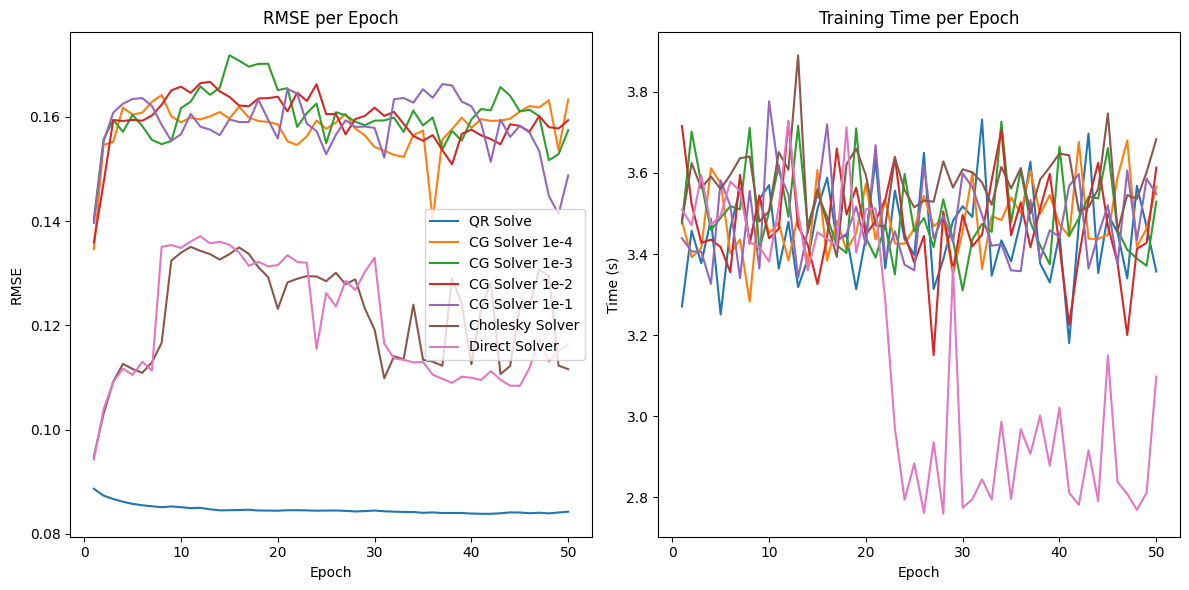

In [15]:
legend_names = ['QR Solve', 'CG Solver 1e-4','CG Solver 1e-3','CG Solver 1e-2','CG Solver 1e-1','Cholesky Solver',"Direct Solver"]
# tolerance_values = [None,1e-4, 1e-3, 1e-2, 1e-1]
plot_results(all_mean_rmse, all_mean_runtimes, all_std_rmse, all_std_runtimes, epochs, legend_names)